In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
#hyper-parameters
image_size = 28*28
h_dim = 400
z_dim = 20
batch_size = 128
num_epochs = 20
learning_rate = 1e-3

In [4]:
from random import shuffle


root = "data/mnist"
train_dataset = datasets.MNIST(root,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root,
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              shuffle=False)

In [5]:
from models.vae import ConvVAE

model = ConvVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

ConvVAE(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2_1): Linear(in_features=256, out_features=20, bias=True)
  (fc2_2): Linear(in_features=256, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=400, bias=True)
  (fc5): Linear(in_features=400, out_features=784, bias=True)
)


In [6]:
sample_dir = 'samples/conv_vae'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

loss_list = []

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_dataloader):
        # Forward pass
        x = x.to(device)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
        reconst_loss = F.binary_cross_entropy(x_reconst, x.view(-1, image_size), size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        loss_list.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(train_dataloader), reconst_loss.item(), kl_div.item()))
    
    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20], Step [10/469], Reconst Loss: 34202.7266, KL Div: 4742.0889
Epoch[1/20], Step [20/469], Reconst Loss: 29036.7441, KL Div: 900.4166
Epoch[1/20], Step [30/469], Reconst Loss: 26945.3945, KL Div: 1127.3757
Epoch[1/20], Step [40/469], Reconst Loss: 26386.1289, KL Div: 587.8383
Epoch[1/20], Step [50/469], Reconst Loss: 26272.8398, KL Div: 649.7811
Epoch[1/20], Step [60/469], Reconst Loss: 26825.6484, KL Div: 580.4075
Epoch[1/20], Step [70/469], Reconst Loss: 25194.0781, KL Div: 568.5413
Epoch[1/20], Step [80/469], Reconst Loss: 26418.9277, KL Div: 453.9604
Epoch[1/20], Step [90/469], Reconst Loss: 26698.1738, KL Div: 575.6749
Epoch[1/20], Step [100/469], Reconst Loss: 25888.6797, KL Div: 696.5806
Epoch[1/20], Step [110/469], Reconst Loss: 26046.0547, KL Div: 578.6259
Epoch[1/20], Step [120/469], Reconst Loss: 26538.1562, KL Div: 526.0050
Epoch[1/20], Step [130/469], Reconst Loss: 24597.3945, KL Div: 722.6393
Epoch[1/20], Step [140/469], Reconst Loss: 24994.7969, KL Div: 748.2836

In [7]:
loss_list = [x.tolist() for x in loss_list]

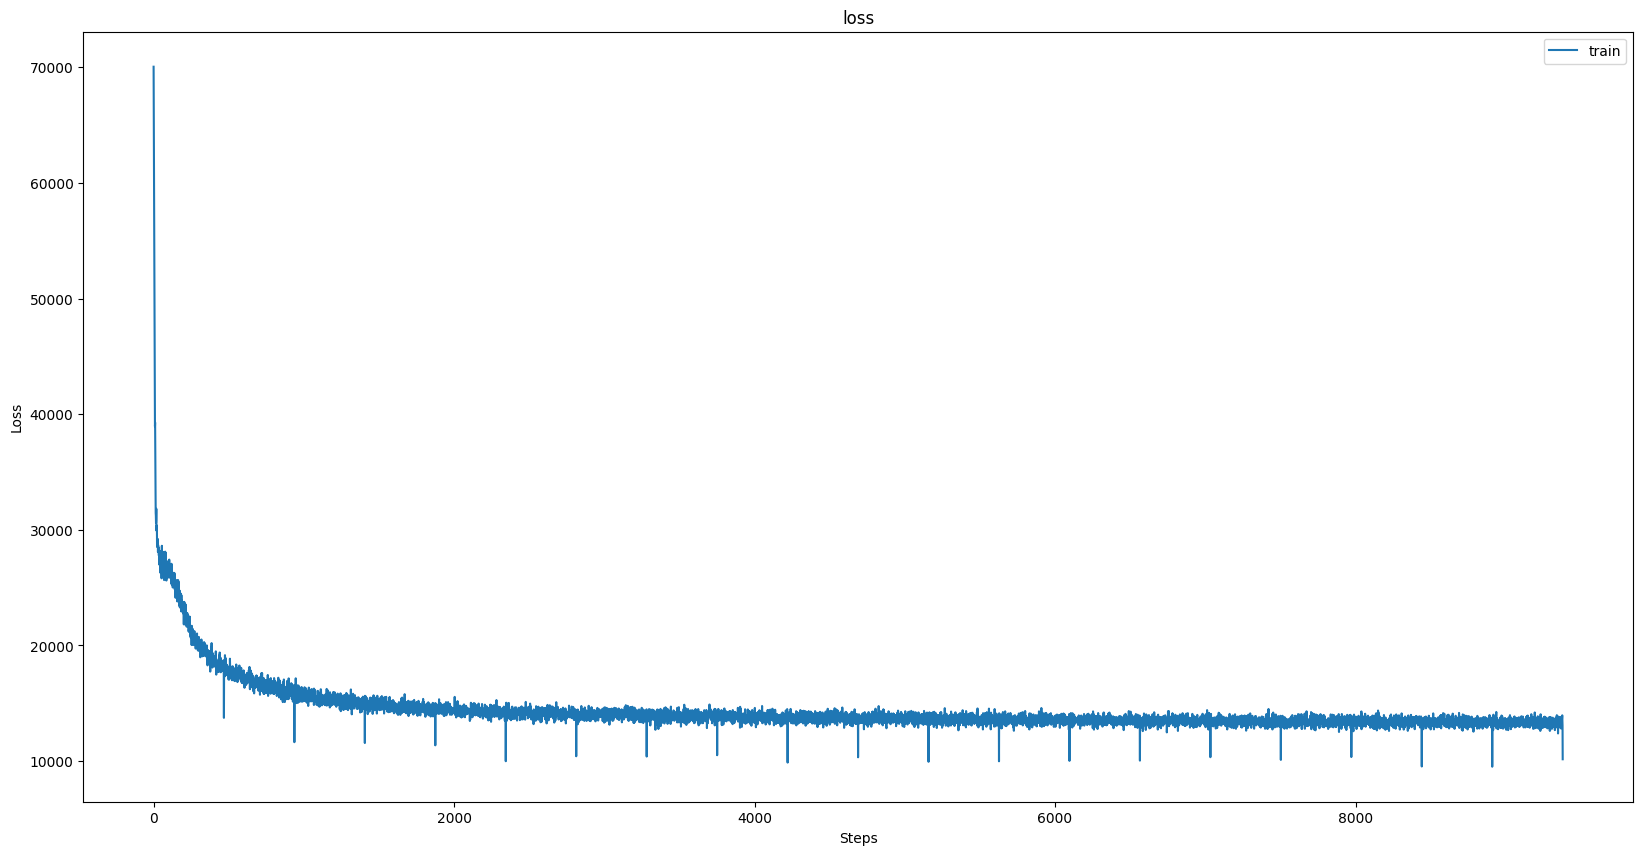

In [8]:
import matplotlib.pyplot as plt

x = list(range(len(loss_list)))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

ax.set_title("loss")
ax.set_xlabel("Steps")
ax.set_ylabel("Loss")

ax.plot(x, loss_list, label="train")
ax.legend()

plt.show()

In [9]:
import numpy as np

x_tsne = []
y_tsne = []

for img, label in test_dataloader:
    img = img.to(device)
    mu, log_var = model.encode(img)
    z = model.reparameterize(mu, log_var)
    x_tsne.append(z.flatten().tolist())
    y_tsne.append(label.item())
x_tsne = np.array(x_tsne)
y_tsne = np.array(y_tsne)

print(x_tsne.shape)
print(y_tsne.shape)


(10000, 20)
(10000,)


In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x_tsne)

print(x_tsne)


/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[[-47.08802     3.807184 ]
 [ -6.3137794 -61.312454 ]
 [-68.20608   -38.42632  ]
 ...
 [-34.267937   48.03757  ]
 [ 34.55705     8.8266   ]
 [ 40.387802   34.625885 ]]


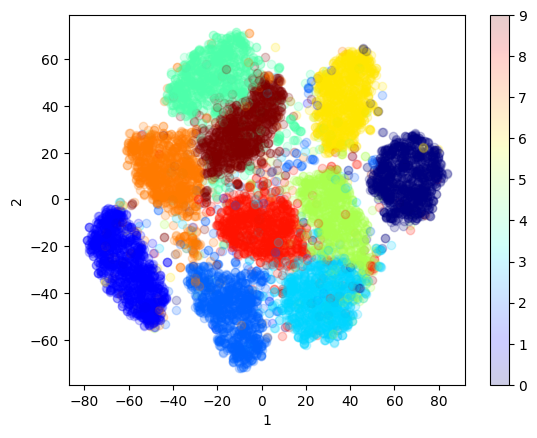

In [11]:
import matplotlib.colors as colors

fig = plt.figure()
ax = fig.add_subplot()

ax.set_xlabel("1")
ax.set_ylabel("2")

for x, y in zip(x_tsne, y_tsne):
    mp = ax.scatter(x[0], x[1],
               alpha=0.2,
               c=y,
               vmin=0,
               vmax=9,
               cmap="jet")

fig.colorbar(mp, ax=ax)

plt.show()